In [1]:
# Getting the image

# Loading and Vectorising it

# Choosing and separating the patches

# Performing matrix factorization

# Recombining the compressed patch with all the values.

In [2]:
# Importing Libraries

import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

from einops import rearrange
from sklearn import preprocessing

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

torch.Size([3, 1365, 2048])


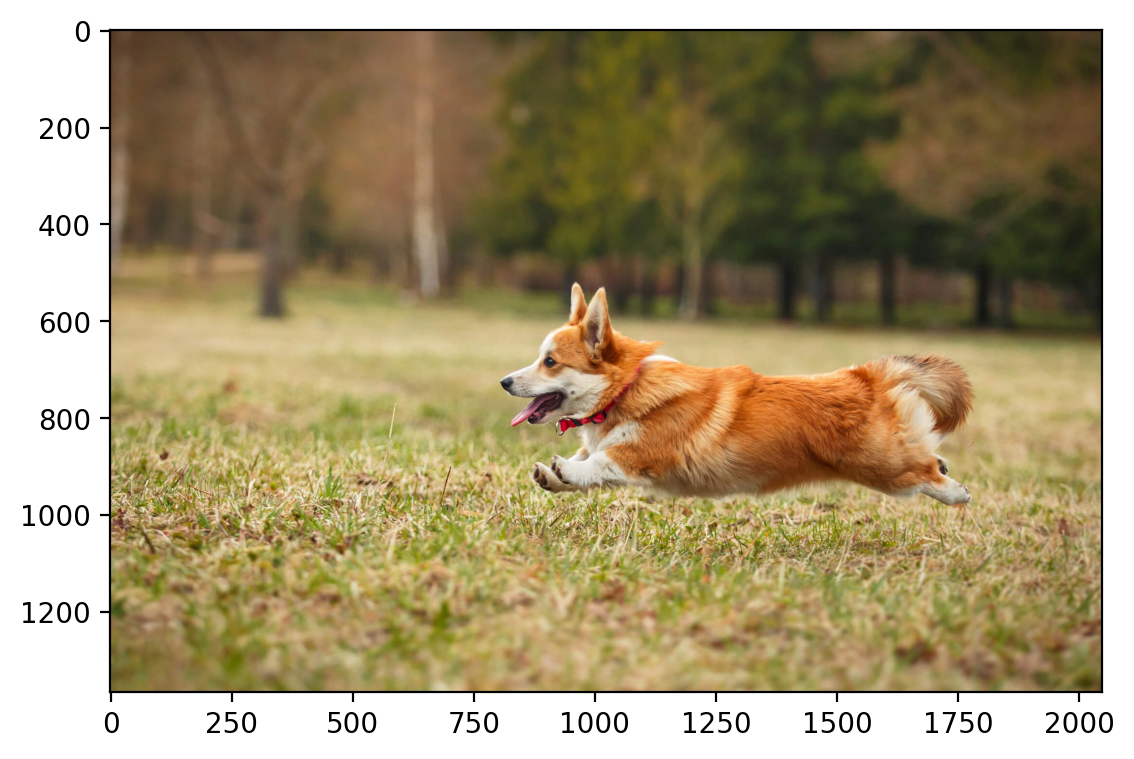

In [3]:
# Reading and showing the image


# Read in a image from torchvision
# This function reads the image and loads it as a tensor. It will have a shape (Color channels, Height, Width)
img = torchvision.io.read_image("..\sample_images\dog.jpg")
print(img.shape)

# Rearranges the axes
# PyTorch typically represents images as tensors with the shape (C, H, W)
# Matplotlib expects images to be in the shape (H, W, C)
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

In [4]:
# Transformation

# preprocessing.MinMaxScaler() is a scaler from the sklearn library that scales data to a specified range, usually between 0 and 1.
# img.reshape(-1, 1) reshapes the image tensor into a 2D array with one column and 3 rows
# -1 means the number of rows is inferred based on the original array size
print(img.shape)

# So basically the 3d array is reduced to a single column to normalise it.
print(img.reshape(-1,1).shape)
# This scler_img stores the transformation
scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))

# Now the transformation is performed using the factors and it is reshaped.
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled = torch.tensor(img_scaled)
print(img_scaled.shape)

img_scaled = img_scaled.to(device)
img_scaled

torch.Size([3, 1365, 2048])
torch.Size([8386560, 1])
torch.Size([3, 1365, 2048])


tensor([[[0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         ...,
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3765, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3804, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3843, 0.3804, 0.3804]],

        [[0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         ...,
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3176, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3216, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3255, 0.3216, 0.3216]],

        [[0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.

torch.Size([3, 300, 300])


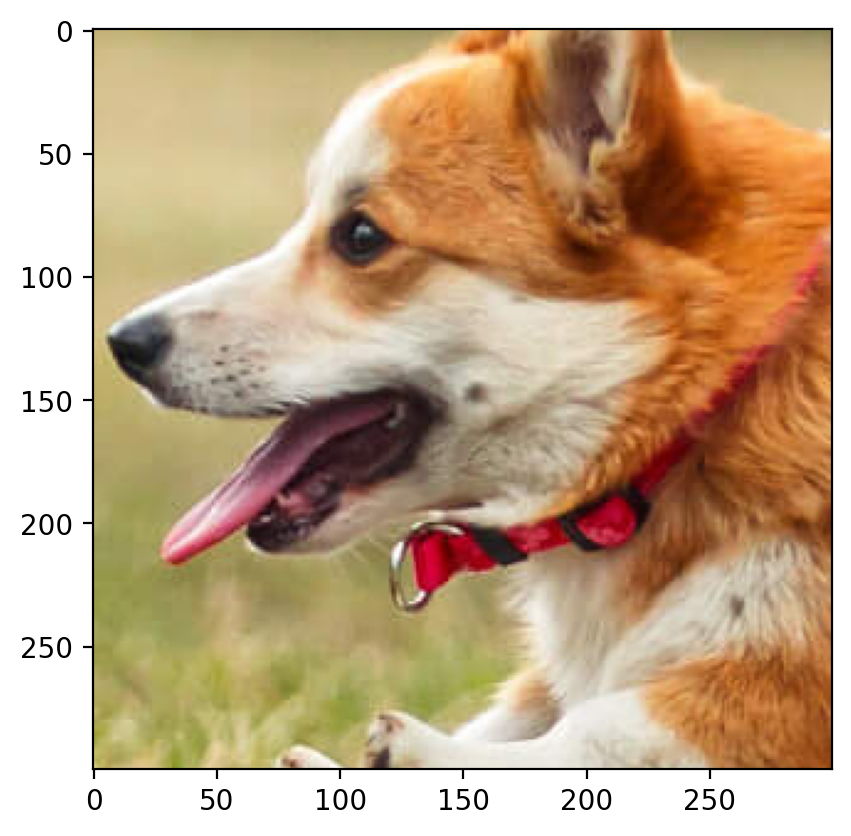

In [5]:
# Cropping the image

# the arguments are  (image, starting[depth], starting[length], length, breadth)
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 600, 800, 300, 300)
print(crop.shape)
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())



In [6]:
# Extract the patch

def extract_patch(new_crop, start_h, start_w, patch_size=50):
    patch = new_crop[:, start_h:start_h + patch_size, start_w:start_w + patch_size]
    # print("Patch shape:", patch.shape) 
    
    return patch


In [21]:
def grad_descent(A, r, device=torch.device("cpu"), tolerance=1e-6, max_iters=1000, alpha=0.01):
    # Randomly initialize W and H
    W = torch.randn(A.shape[0], r, requires_grad=True, device=device)
    H = torch.randn(r, A.shape[1], requires_grad=True, device=device)

    for i in range(max_iters*10):
        reconstructed = torch.mm(W, H)
        
        # Compute the loss
        loss = torch.norm(reconstructed - A)
        
        # Zero the gradients
        W.grad = None
        H.grad = None
        
        # Compute gradients manually
        loss.backward()
        
        # Update W and H
        with torch.no_grad():
            W -= alpha * W.grad
            H -= alpha * H.grad

        # Check for convergence
        if loss.item() < tolerance:
            print(f"Converged at epoch {i} with loss: {loss.item()}")
            break

    return W, H, loss

In [8]:
# Apply factorize on all the three channels one by one 

def factorize(A, r, device=torch.device("cpu"), tolerance=1e-6, max_iters=1000, alpha=0.01):
    # Randomly initialize W and H
    W = torch.randn(A.shape[0], r, requires_grad=True, device=device)
    H = torch.randn(r, A.shape[1], requires_grad=True, device=device)
    
    # Optimizer
    optimizer = optim.Adam([W, H], lr=alpha)
    
    # Train the model
    for i in range(max_iters):
        # Compute the loss
        loss = torch.norm(torch.mm(W, H) - A)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Backpropagate
        loss.backward(retain_graph=True)
        
        # Update the parameters
        optimizer.step()

        if loss.item() < tolerance:
            # print(f"Converged at iteration {i} with loss: {loss.item()}")
            break
        
    return W, H, loss

def factorization_to_channels(tensor, r, device=torch.device("cpu"), iters=1000, alpha=0.01): 
    new_tensor = torch.zeros_like(tensor).to(device)

    for channel in range(tensor.shape[0]):
        A = tensor[channel]  # Get the 2D matrix for the current channel
        W, H, loss = grad_descent(A, r, device=device, max_iters=iters, alpha=alpha)  # Factorize the 2D matrix
        new_tensor[channel] = torch.mm(W, H)
        # print(f"Loss of channel {channel}: ", loss.item())

    return new_tensor
    



In [9]:
# Visualising the patches

def plot_patches(patch, compress_patch):
    fig, axes = plt.subplots(1, 2, figsize=(5, 3))

    # Plot the extracted patch
    # print(patch)
    axes[0].imshow(rearrange(patch, 'c h w -> h w c').cpu().detach().numpy())
    axes[0].set_title('Extracted Patch')

    # Plot the compressed patch
    # print(compress_patch)
    axes[1].imshow(rearrange(compress_patch, 'c h w -> h w c').cpu().detach().numpy())
    axes[1].set_title('Compressed Patch')

    plt.show()

In [10]:
def compute_rmse(patch, compressed_patch):
    # Compute the RMSE
    mse = torch.mean((patch - compressed_patch) ** 2)
    rmse = torch.sqrt(mse)
    return rmse.item()

def compute_psnr(patch, compressed_patch, max_pixel=1.0):
    # Compute the RMSE
    rmse = compute_rmse(patch, compressed_patch)
    # Compute PSNR
    psnr = 20 * np.log10(max_pixel / rmse)
    return psnr

In [11]:
def compress_and_compare(new_crop, start_h, start_w, rank, patch_size=50, iters=1000, alpha=0.01):
    patch = extract_patch(new_crop, start_h, start_w, patch_size)
    compressed_patch = factorization_to_channels(patch, rank, iters=iters, alpha=alpha)
    
    plot_patches(patch, compressed_patch)
    RMSE = compute_rmse(patch, compressed_patch)
    PSNR = compute_psnr(patch, compressed_patch)
    return compressed_patch, RMSE, PSNR


In [12]:
# Recombining the patch
def recombine(new_crop, patch, start_h, start_w):
    for i in range(patch.shape[0]):
        for j in range(patch.shape[1]):
            for k in range(patch.shape[2]):
                new_crop[i][start_h+j][start_w+k]=patch[i][j][k]

    plt.imshow(rearrange(new_crop, 'c h w -> h w c').cpu().detach().numpy())
    return new_crop

Patch 1
h: 0 
w: 0
Rank:  5


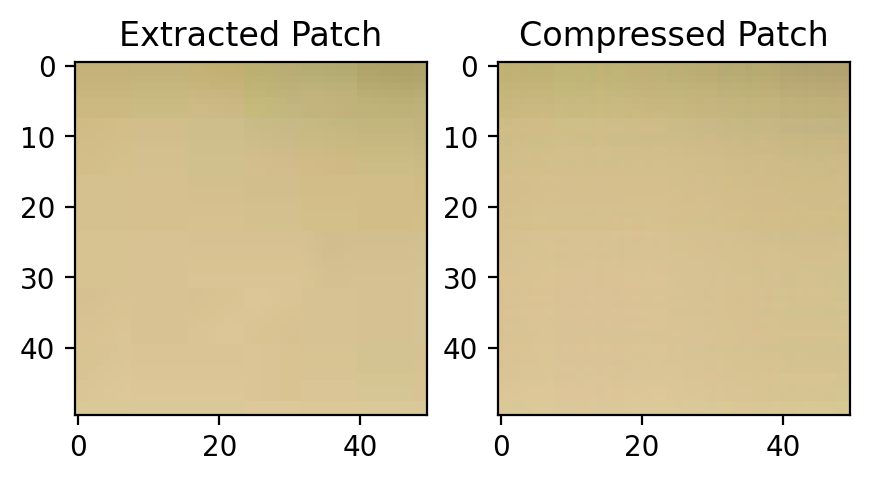

RMSE:  0.007308392551666609
PSNR:  42.723562673450594
------------------

Rank:  10


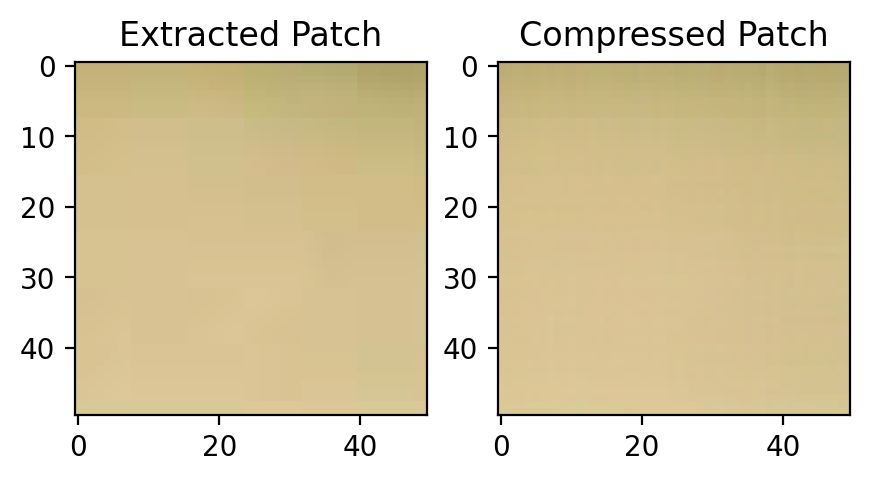

RMSE:  0.007981642331763811
PSNR:  41.95815474883402
------------------

Rank:  25


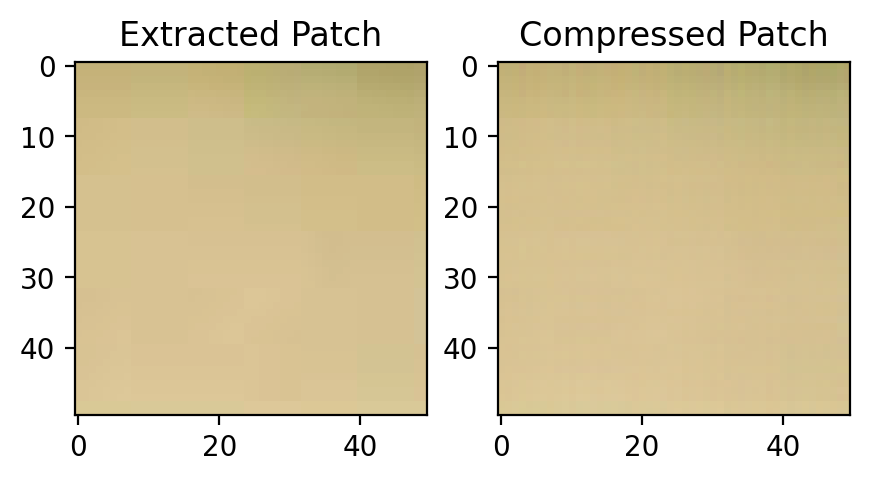

RMSE:  0.005172657817292519
PSNR:  45.72572500354434
------------------

Rank:  50


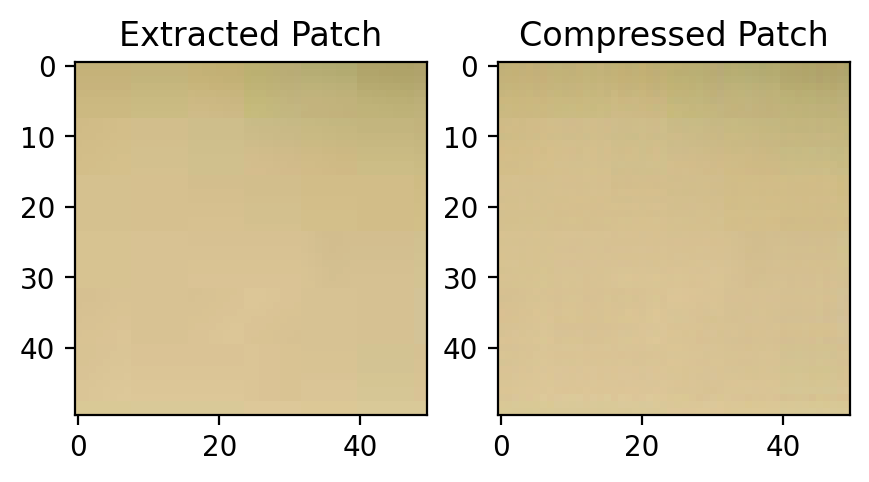

RMSE:  0.00394354455562153
PSNR:  48.08226495981856
------------------



In [25]:
# Selecting a patch
patch_size = 50
iterations = 1000
alpha = 0.001

# Patch 1

h = 0  # Starting height (row)
w = 0  # Starting width (column)
print("Patch 1")
print("h:", h, "\nw:", w)

for i in ([5,10,25,50]):
    new_crop = crop.detach().clone()
    print("Rank: ", i)
    compress_patch, RMSE, PSNR = compress_and_compare(new_crop, h, w, rank=i, iters=iterations, alpha=alpha)

    print("RMSE: ", RMSE)
    print("PSNR: ", PSNR)
    print("------------------\n")

Patch 2
h: 50 
w: 50
Rank:  5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


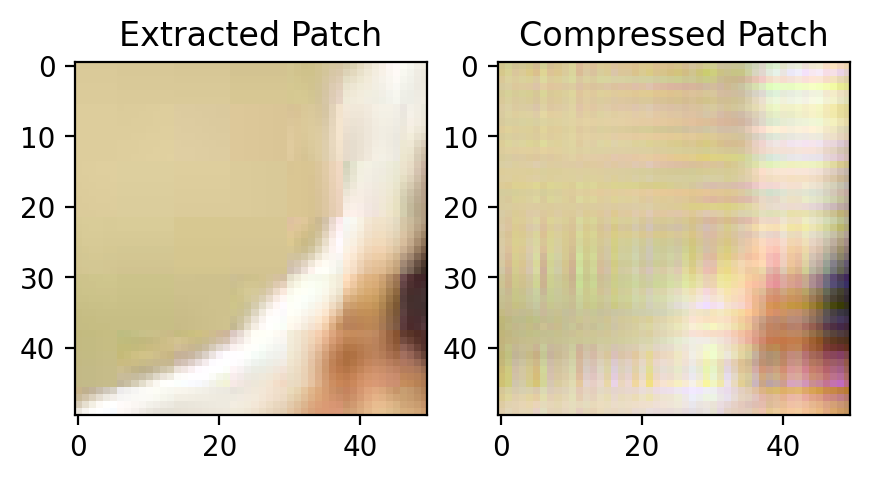

RMSE:  0.06973051118647333
PSNR:  23.13154302039587
------------------

Rank:  10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


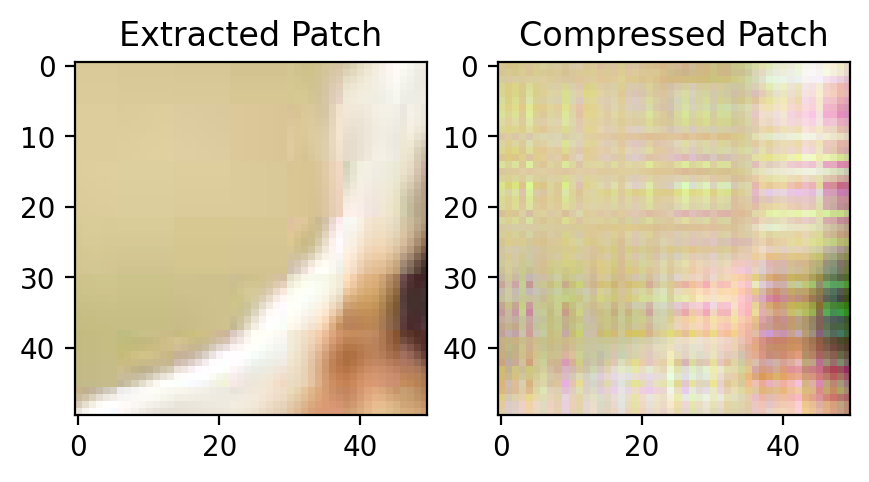

RMSE:  0.08386231239867885
PSNR:  21.528663332772453
------------------

Rank:  25


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


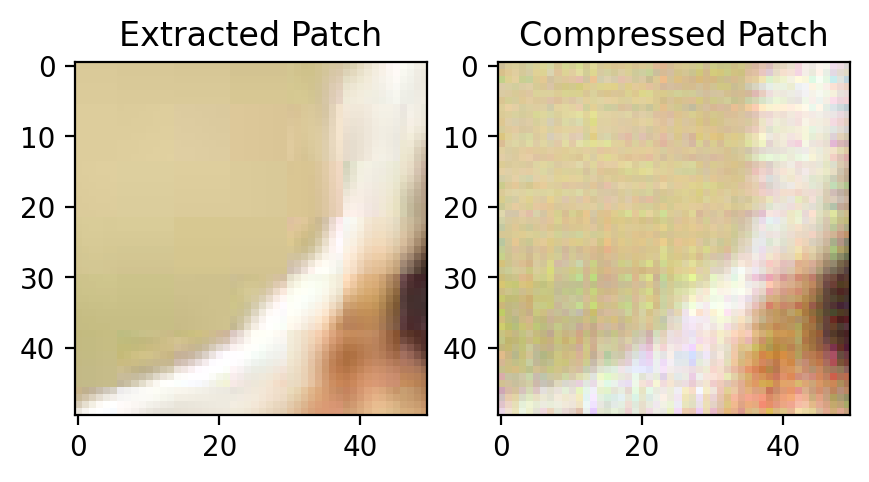

RMSE:  0.04249875445072397
PSNR:  27.432475960454603
------------------

Rank:  50


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


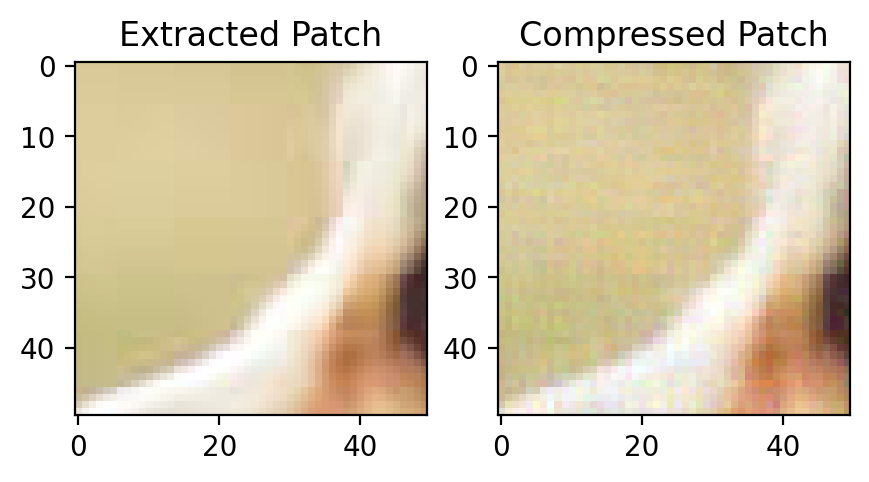

RMSE:  0.024469153702307504
PSNR:  32.22762102062567
------------------



In [26]:
# Patch 2

h = 50  # Starting height (row)
w = 50  # Starting width (column)
print("Patch 2")
print("h:", h, "\nw:", w)

for i in ([5,10,25,50]):
    new_crop = crop.detach().clone()
    print("Rank: ", i)
    compress_patch, RMSE, PSNR = compress_and_compare(new_crop, h, w, rank=i, iters=iterations, alpha=alpha)

    print("RMSE: ", RMSE)
    print("PSNR: ", PSNR)
    print("------------------\n")

Patch 3
h: 175 
w: 90
Rank:  5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


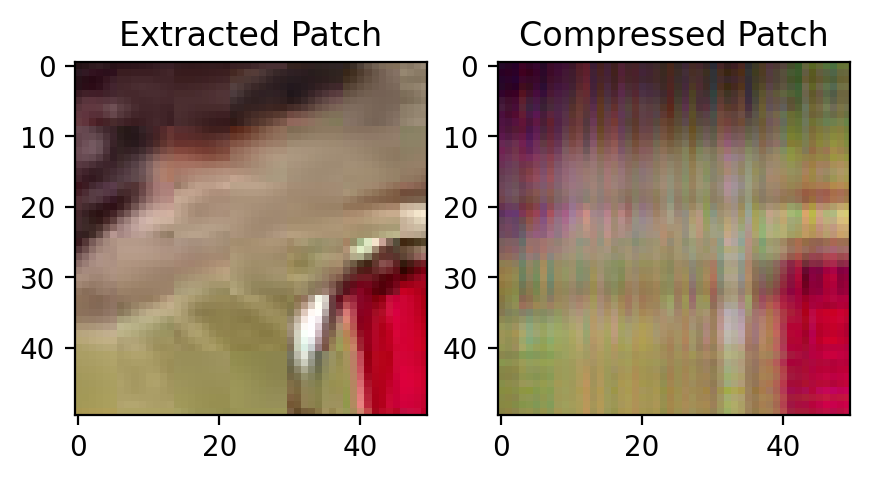

RMSE:  0.09554909385286266
PSNR:  20.395468545087287
------------------

Rank:  10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


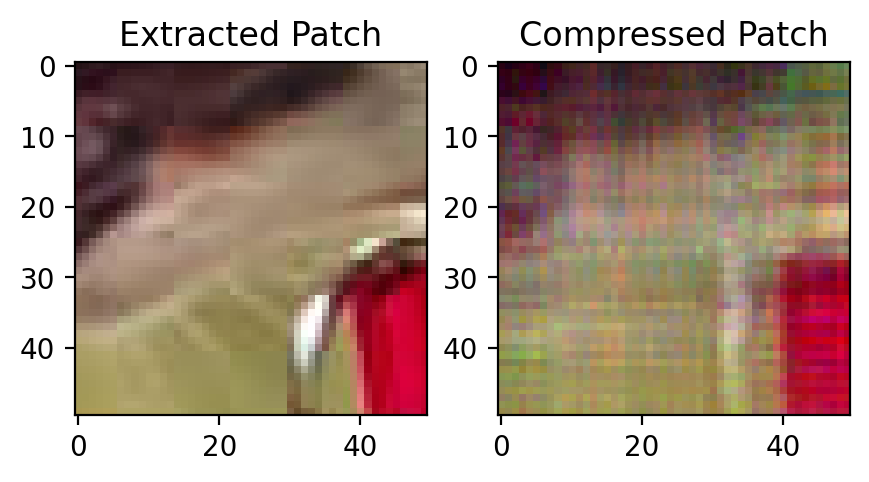

RMSE:  0.0872906050318831
PSNR:  21.180649925974564
------------------

Rank:  25


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


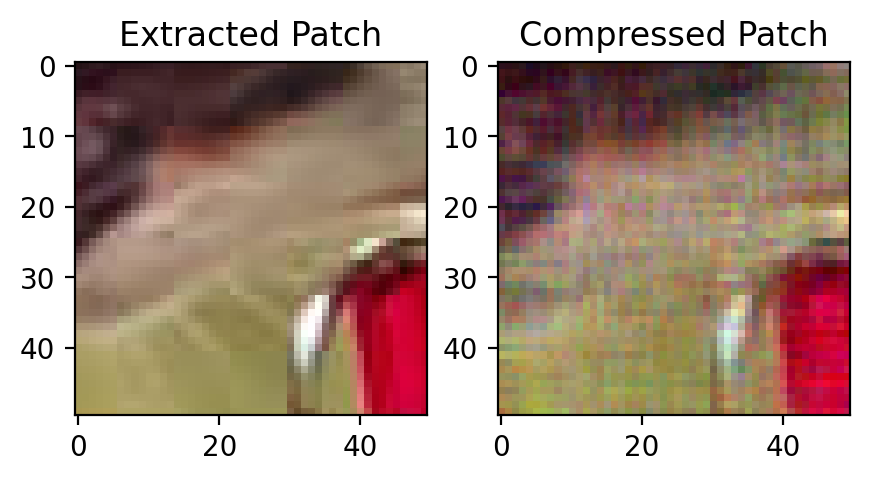

RMSE:  0.06450835464912695
PSNR:  23.807680701699773
------------------

Rank:  50


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


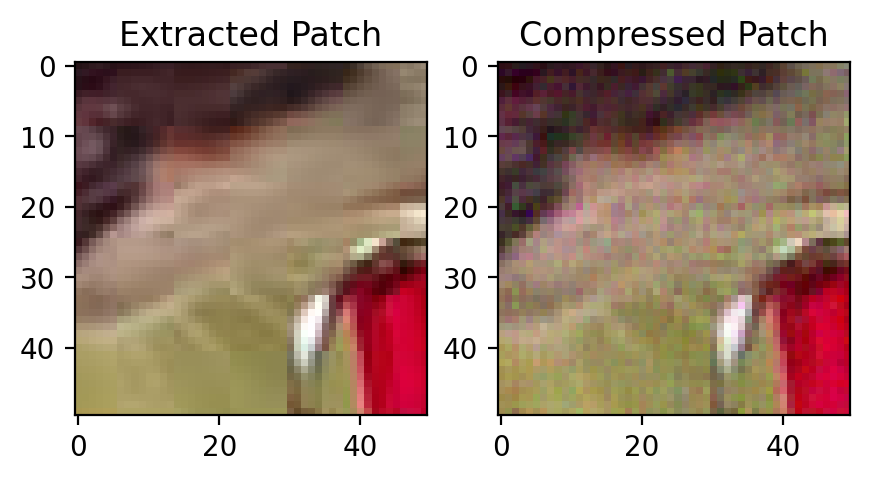

RMSE:  0.03733158324146386
PSNR:  28.55847182298445
------------------



In [27]:
# Patch 3

h = 175  # Starting height (row)
w = 90   # Starting width (column)
print("Patch 3")
print("h:", h, "\nw:", w)

for i in ([5,10,25,50]):
    new_crop = crop.detach().clone()
    print("Rank: ", i)
    compress_patch, RMSE, PSNR = compress_and_compare(new_crop, h, w, rank=i, iters=iterations, alpha=alpha)

    print("RMSE: ", RMSE)
    print("PSNR: ", PSNR)
    print("------------------\n")